In [1]:
import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from sklearn.decomposition import PCA


biotransformer = pd.read_csv("/home/samuel/honours_redo/publication_work/biotransformer_output_phaseII.csv").append(pd.read_csv("/home/samuel/honours_redo/publication_work/biotransformer_output_cyp1.csv"))
gloryx3 = pd.read_csv("/home/samuel/honours_redo/publication_work/gloryX_metabolites.csv")
gloryx = pd.read_csv("/home/samuel/honours_redo/publication_work/gloryX_metabolites.csv")

In [3]:
def normalize_smiles(smi):
    try:
        smi_norm = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
        return smi_norm
    except:
        return np.nan

biotransformer['smiles'] = biotransformer['SMILES'].apply(lambda x: normalize_smiles(x))
biotransformer = biotransformer.dropna(axis=0,subset=['smiles'])

RDKit ERROR: [14:22:13] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [14:22:13] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [14:22:13] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [14:22:13] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [14:22:13] Explicit valence for atom # 10 N, 4, is greater than permitted


In [4]:
def get_fingerprint(df, function):
    if function != "Morgan":
        fn = function
        df1 = df.copy()
        df1['fp_list'] = df1['smiles'].apply(lambda x: list(fn(Chem.MolFromSmiles(x))))
        df1 = df1.dropna(axis = 1, how = 'any')

        df2 = pd.DataFrame(df1['fp_list'].to_list())
        df2 = df2.applymap(number_check).dropna(axis =1, how = "any")
        df2 = df2.drop(columns=df2.columns[(df2 == 'broken').any()])
        df1['fp_list'] = df2.values.tolist()
        X = np.array(df1['fp_list'].to_list())
        return X
    else:
        radius = 3
        df1 = df.copy()
        df1['fp_list'] = df1['smiles'].apply(lambda x: list(AllChem.GetMorganFingerprint(Chem.MolFromSmiles(x),radius).ToBinary()))
        df2 = pd.DataFrame(df1['fp_list'].to_list())
        df2 = df2.applymap(number_check).dropna(axis =1, how = "any")
        df2 = df2.drop(columns=df2.columns[(df2 == 'broken').any()])
        df1['fp_list'] = df2.values.tolist()
        X = np.array(df1['fp_list'].to_list())

        return X

def number_check(x):
    try:
        return float(x)
    except:
        return "broken"

In [5]:
pca = PCA(n_components=2)

bt_data_printed = get_fingerprint(biotransformer, Chem.RDKFingerprint)
gx_data_printed = get_fingerprint(gloryx, Chem.RDKFingerprint)

pca.fit(np.append(gx_data_printed,bt_data_printed,0))
bt_data_pca = pca.transform(bt_data_printed)
gx_data_pca = pca.transform(gx_data_printed)

/home/samuel/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/samuel/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-20.0, 20.0)

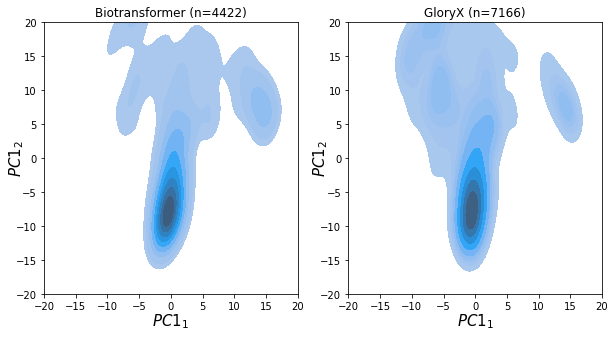

In [6]:

bt_y = [i[0] for i in bt_data_pca];     bt_x = [i[1] for i in bt_data_pca]
gx_y = [i[0] for i in gx_data_pca];     gx_x = [i[1] for i in gx_data_pca]

fig, axs = plt.subplots(1, 2,figsize = (10,5))
sns.kdeplot(bt_x,bt_y, fill = True, ax = axs[0])
sns.kdeplot(gx_x,gx_y, fill = True, ax = axs[1])
axs[0].set_title("Biotransformer (n="+str(len(bt_y))+")"); axs[1].set_title("GloryX (n="+str(len(gx_y))+")")
axs[0].set_xlabel('$PC1_1$', fontsize = 15, labelpad=0);axs[1].set_xlabel('$PC1_1$', fontsize = 15, labelpad=0)
axs[0].set_ylabel('$PC1_2$', fontsize = 15, labelpad=-10);axs[1].set_ylabel('$PC1_2$', fontsize = 15, labelpad=-10)
axs[0].set_xlim(-20, 20);axs[1].set_xlim(-20, 20)
axs[0].set_ylim(-20, 20);axs[1].set_ylim(-20, 20)

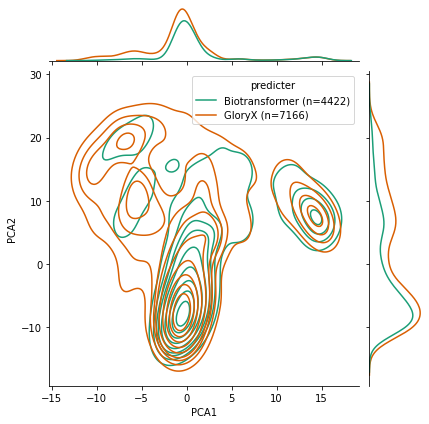

In [7]:
graph_df = pd.DataFrame(list(zip(bt_x,bt_y)),columns=['PCA1','PCA2']); graph_df['predicter'] = 'Biotransformer (n='+str(len(bt_x))+")"
test_df = pd.DataFrame(list(zip(gx_x,gx_y)),columns=['PCA1','PCA2']); test_df['predicter'] = 'GloryX (n='+str(len(gx_x))+")"
graph_df = graph_df.append(test_df)
graph_df = graph_df.reset_index(drop=True)

sns.jointplot(
    data=graph_df,
    x="PCA1", y="PCA2", hue="predicter",
    kind="kde", palette='Dark2'
)